<a href="https://colab.research.google.com/github/yuntai/yuntai/blob/master/projects/GAS/GAS2_CATBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import sys
running_in_colab = 'google.colab' in sys.modules

In [29]:
from pathlib import Path
if running_in_colab:
  from google.colab import drive
  drive.mount("/content/drive")
  rootdir = Path("/content/drive/My Drive/DATASETS/YONSEI/GAS2")
else:
  rootdir = Path("/mnt/DATASETS/YONSEI/GAS2")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!pip install -U catboost
!pip install wget
!pip install xlrd
!pip install seaborn

Requirement already up-to-date: catboost in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [31]:
#import wget
#gas_id="1q947bsibhAtuyCmB3hbfy6XBd9y_RLbM"
#inout_id="1OEB9KG7K1RvTgvSQ2rtYLD0PiTzQpD2X"
#__get_link=lambda _id: f"https://docs.google.com/uc?export=download&id={_id}"
#GAS_FN = 'gas_fixed_8.xlsx'
#INOUT_FN = 'gas_inout.xlsx'
#!rm -f {GAS_FN} {INOUT_FN}
#print(wget.download(__get_link(gas_id), GAS_FN))
#print(wget.download(__get_link(inout_id), INOUT_FN))
#!ls

In [32]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import sklearn
import collections
from catboost import CatBoostClassifier
import seaborn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool, cv
import re
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use('seaborn')

plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')


In [33]:
GAS_FN = rootdir/'gas_fixed_9.xlsx'
GAS_INOUT_FN = rootdir/'gas_inout.xlsx'

# Preprocessing

In [34]:
import pandas as pd
import xlrd

mapping0 = {
  '아세톤':'A',
  '톨루엔':'T',
  '자일렌':'X',
  '아&자11':'AX11',
  '아&자13':'AX13',
  '아&자31':'AX31',
  '아&톨11':'AT11',
  '아&톨13':'AT13',
  '아&톨31':'AT31',
  '톨&자11':'TX11',
  '톨&자13':'TX13',
  '톨&자31':'TX31',
  '톨&자&아111':'TXA111'
}

sheets_mapping = {
  'Acetone':'A',
  'Toluene':'T',
  'Xylene':'X',
  'A&X 11':'AX11',
  'A&X 13':'AX13',
  'A&X 31':'AX31',
  'T&A 11':'AT11',
  'T&A 31':'AT13',
  'T&A 13':'AT31',
  'T&X 11':'TX11',
  'T&X 13':'TX13',
  'T&X 31':'TX31',
  'T&X&A 111': 'TXA111',
}

def read_sheet(name):
    df = pd.read_excel(GAS_FN, name)
    cols_to_drop = [c for c in df.columns if c.startswith('Unnamed:') or c.startswith('No..')]
    df.drop(cols_to_drop, axis=1, inplace=True)
    df.rename(columns={'No.': 't'}, inplace=True)
    return df

def read_inout():
    df = pd.read_excel(GAS_INOUT_FN)
    df = df.iloc[:, 3:]
    df.rename(columns=mapping0, inplace=True)
    res = {}
    for c in df.columns:
        L = df[c].tolist()
        R = [L[i:i+3] for i in range(0,len(L)-1,2)]
        for r in R[:-1]:
            r[-1] -= 1
        assert len(R) == 10
        res[c] = R
    return res

channels = ['CH21','CH34','CH37','CH12','CH35','CH38','CH33','CH36','CH19']
channels = dict(enumerate(channels))
rchanmap = {i: k for i, k in channels.items()}

In [35]:
w = xlrd.open_workbook(GAS_FN)
names = w.sheet_names()
sheets = {}
for n in tqdm(names):
  df = read_sheet(n)
  df.set_index('t', inplace=True)
  sheets[sheets_mapping[n]] = df

tm_df = read_inout()

gas_types = dict(enumerate(tm_df.keys()))
rgastypes = {v:k for k, v in gas_types.items()}

100%|██████████| 13/13 [00:43<00:00,  3.33s/it]


In [36]:
# normalization
sheets_norm = {}
ppm = np.concatenate([10./np.array([2,4,6,8,10])]*2, axis=-1)
for k in sorted(tm_df.keys()):
  tms = tm_df[k]
  df = sheets[k].copy()
  for (r0, _, r2), p in zip(tms, ppm):
    df.loc[r0:r2,:] = df.loc[r0:r2,:] * p
  sheets_norm[k] = df

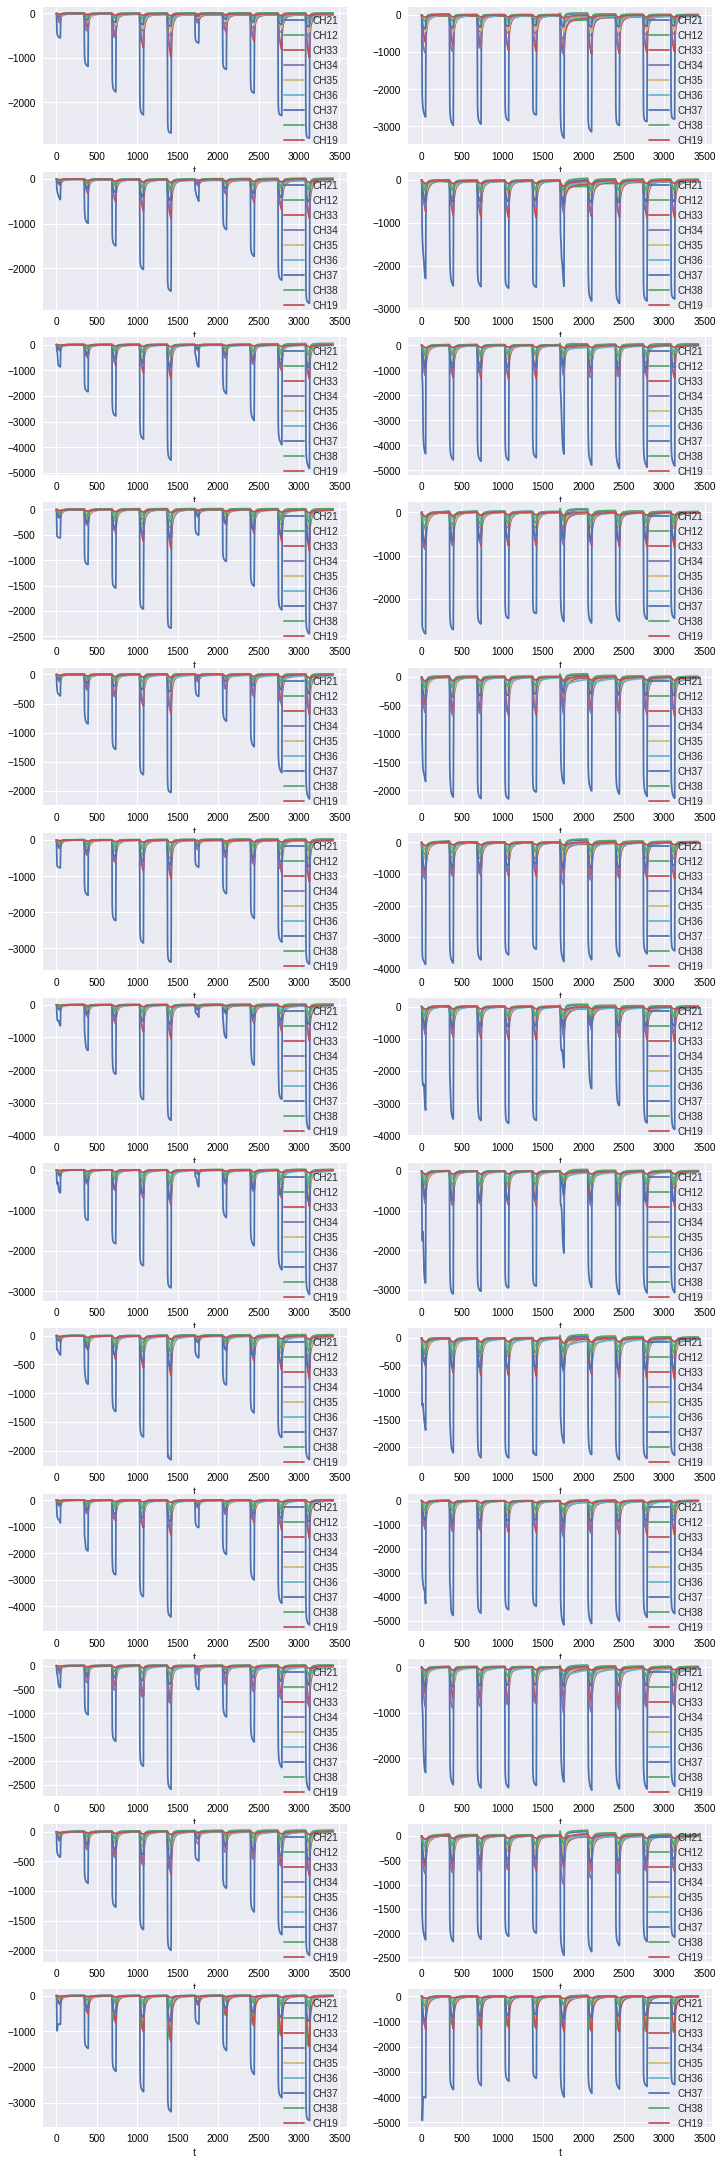

In [37]:
# normalization result visualization
fig, axes = plt.subplots(len(sheets), 2, figsize=(12, 3*len(sheets)))
for i, k in enumerate(sheets):
  sheets[k].plot(ax=axes[i,0])
  sheets_norm[k].plot(ax=axes[i,1])

[1, 50, 342]


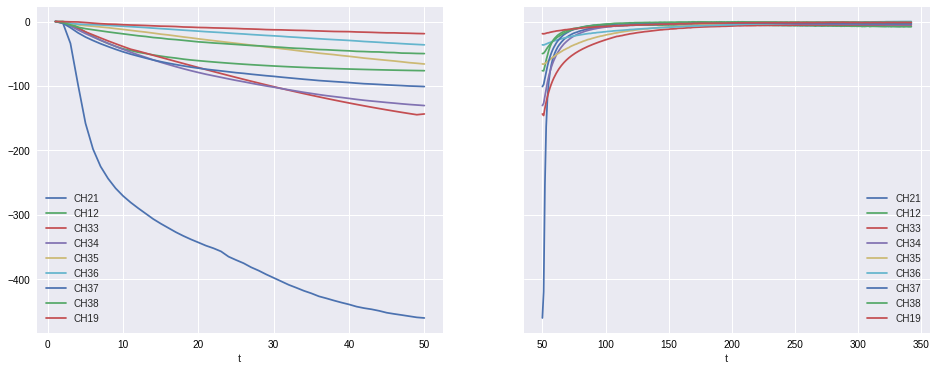

In [38]:
r = tm_df['A'][0]
print(r)
_, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)
sheets['A'].loc[r[0]:r[1]].plot(ax=axes[0]);
sheets['A'].loc[r[1]:r[2]].plot(ax=axes[1]);

In [39]:
def build_target_sheets():
  target_sheets = {}
  keys = sorted(tm_df.keys())
  #combo_keys = [k for k in keys if k!='TXA111']
  xs, ys = [], []
  for k in keys:
    print(f"processing target {k}...")
    tm = tm_df[k]
    df = pd.DataFrame(data=np.array(tm), columns=["x0", "x1", "x2"])
    df['target'] = k
    df['target_k'] = re.match(r'^[ATX]+', k).group()
    tp = re.search(r'\d\d', k)
    if tp:
      tp = tp.group()
    df['target_p'] = tp
    target_sheets[k] = df
  return target_sheets    

def build_exp_sheets(target_sheets):
  exp_sheets = {}
  for t in ["AT", "AX", "TX"]:
    print(f"bulding exp seet {t}")
    exp_sheets[t] = pd.concat([target_sheets[t+k] for k in ["11", "13", "31"]])
    exp_sheets[t] = pd.concat([exp_sheets[t]]+[target_sheets[s] for s in t])
  return exp_sheets    

def build_exp_sheets_all(target_sheets):
  exp_sheets = {}
  for t in ["AT", "AX", "TX"]:
    print(f"bulding exp seet {t}")
    exp_sheets[t] = pd.concat([target_sheets[t+k] for k in ["11", "13", "31"]])
    exp_sheets[t] = pd.concat([exp_sheets[t]]+[target_sheets[s] for s in t])
  return exp_sheets    
  
target_sheets = build_target_sheets()
exp_sheets = build_exp_sheets(target_sheets)
exp_sheets_all = pd.concat(target_sheets.values())

processing target A...
processing target AT11...
processing target AT13...
processing target AT31...
processing target AX11...
processing target AX13...
processing target AX31...
processing target T...
processing target TX11...
processing target TX13...
processing target TX31...
processing target TXA111...
processing target X...
bulding exp seet AT
bulding exp seet AX
bulding exp seet TX


In [40]:
assert exp_sheets_all.shape[0] == 13 * 10 #  13 kinds * 10 experiments
assert all(v.shape[0]==5*10 for v in exp_sheets.values())

In [41]:
print(exp_sheets.keys())
print(exp_sheets['AT'].head())
print(exp_sheets['AT'].target.unique())

dict_keys(['AT', 'AX', 'TX'])
     x0    x1    x2 target target_k target_p
0     1    50   342   AT11       AT       11
1   343   392   685   AT11       AT       11
2   686   735  1027   AT11       AT       11
3  1028  1076  1369   AT11       AT       11
4  1370  1419  1710   AT11       AT       11
['AT11' 'AT13' 'AT31' 'A' 'T']


In [42]:
print(exp_sheets_all.target.unique())
exp_sheets_all.head()

['A' 'AT11' 'AT13' 'AT31' 'AX11' 'AX13' 'AX31' 'T' 'TX11' 'TX13' 'TX31'
 'TXA111' 'X']


,x0,x1,x2,target,target_k,target_p
0,1,50,342,A,A,None
1,343,392,684,A,A,None
2,685,734,1027,A,A,None
3,1028,1077,1369,A,A,None
4,1370,1419,1710,A,A,None


## Building Features

In [43]:
TC_props = np.arange(0.1, 1.0, 0.1)

def build_features(gas_sheets, df, th=0.1):
  cnt = 0
  exp_df = df.copy().reset_index(drop=True)
  features = collections.defaultdict(list)

  for _, row in exp_df.iterrows(): # one row corresponds to one experiment (one cycle of graph)
    gas_df = gas_sheets[row.target]
    num_sensors = gas_df.shape[1]

    features[f"mag_peak"].append(gas_df.loc[row.x1, :])
  
    # get constant time and corresponding magnitude value in **up** phases
    mag_up = gas_df.loc[row.x0:row.x1, :] - gas_df.loc[row.x0, :]
    mag_up_range = (gas_df.loc[row.x1,:] - gas_df.loc[row.x0, :]).abs()
    prop = mag_up.abs() / mag_up_range
    diff_up = mag_up.abs().diff(3)/3.

    for p in TC_props:
      tms, vals, diffs = [], [], []
      for k in range(num_sensors):
        s = prop.iloc[:,k]
        m = mag_up.iloc[:, k]
        d = diff_up.iloc[:, k]
        tm = s[s >= p].index[0]
        vals.append(m[tm])
        diffs.append(d[tm])
        tms.append(tm - row.x0)
      features[f'TC_up_{p:.1f}'].append(pd.Series(tms, index=gas_df.columns))
      features[f'mag_up_{p:.1f}'].append(pd.Series(vals, index=gas_df.columns))
      features[f'diff_up_{p:.1f}'].append(pd.Series(diffs, index=gas_df.columns))
  
    # get constant time and corresponding magnitude value in **down** phases
    mag_dn = gas_df.loc[row.x1:row.x2, :] - gas_df.loc[row.x1, :]
    prop = mag_dn.abs() / mag_dn.abs().iloc[-1,:]
    diff_dn = mag_dn.abs().diff(3)/3.
    for p in TC_props:
      tms, vals, diffs = [], [], []
      for k in range(num_sensors):
        s = prop.iloc[:,k]
        m = mag_dn.iloc[:, k]
        d = diff_dn.iloc[:, k]
        tm = s[s >= p].index[0]
        vals.append(m[tm])
        diffs.append(d[tm])
        tms.append(tm - row.x1)
      features[f'TC_dn_{p:.1f}'].append(pd.Series(tms, index=gas_df.columns))
      features[f'mag_dn_{p:.1f}'].append(pd.Series(vals, index=gas_df.columns))
      features[f'diff_dn_{p:.1f}'].append(pd.Series(diffs, index=gas_df.columns))

    recs = []
    for k in range(num_sensors):
      d = diff_dn.iloc[:, k]
      #TODO: change to bisect
      if d[d < th].shape[0] == 0:
        cnt += 1
        recs.append(row.x2 - row.x1)
      else:
        recs.append(d[d < th].index[0] - row.x1)
    features[f'T_rec'].append(pd.Series(recs, index=gas_df.columns))
  
    diff = gas_df.loc[row.x0:row.x2, :].diff(3).iloc[3:,:]/3.
    max_diff = diff.max()
    min_diff = diff.min()

    features['diff_at_peak'].append(diff.loc[row.x1+1,:])
    
    # cutting heading null since we are only calculating global var
    diff_up = gas_df.loc[row.x0:row.x1, :].diff(3).iloc[3:,:]/3 
    diff_dn = gas_df.loc[row.x1:row.x2, :].diff(3).iloc[3:,:]/3
    assert diff_up.isna().sum().sum() == 0
    assert diff_dn.isna().sum().sum() == 0

    max_diff_up = diff_up.max()
    min_diff_up = diff_up.min()
    max_diff_dn = diff_dn.max()
    min_diff_dn = diff_dn.min()
  
    features['max_diff'].append(max_diff) # max derivtive
    features['min_diff'].append(min_diff) # min derivative
    features['max_diff_up'].append(max_diff_up) # max derivative up
    features['min_diff_up'].append(min_diff_up) # min derivative down
    features['max_diff_dn'].append(max_diff_dn) # max dreivative up
    features['min_diff_dn'].append(min_diff_dn) # min derivative down
  
  # --------------------------------------------------------
  keys = sorted(features.keys())
  feats = {}
  for k in keys:
    ser = features[k]
    ser = pd.concat(ser, axis=1).transpose()
    ser.columns = [f'{k}_{c}' for c in ser.columns]
    ser.reset_index(drop=True, inplace=True)
    feats[k] = ser

  exp_df = pd.concat([exp_df]+list(feats.values()), axis=1)
  #print(cnt)
  return exp_df

In [44]:
exp_dfs = {k: build_features(sheets_norm, exp_sheets[k]) for k in exp_sheets}
exp_df_all = build_features(sheets_norm, exp_sheets_all)

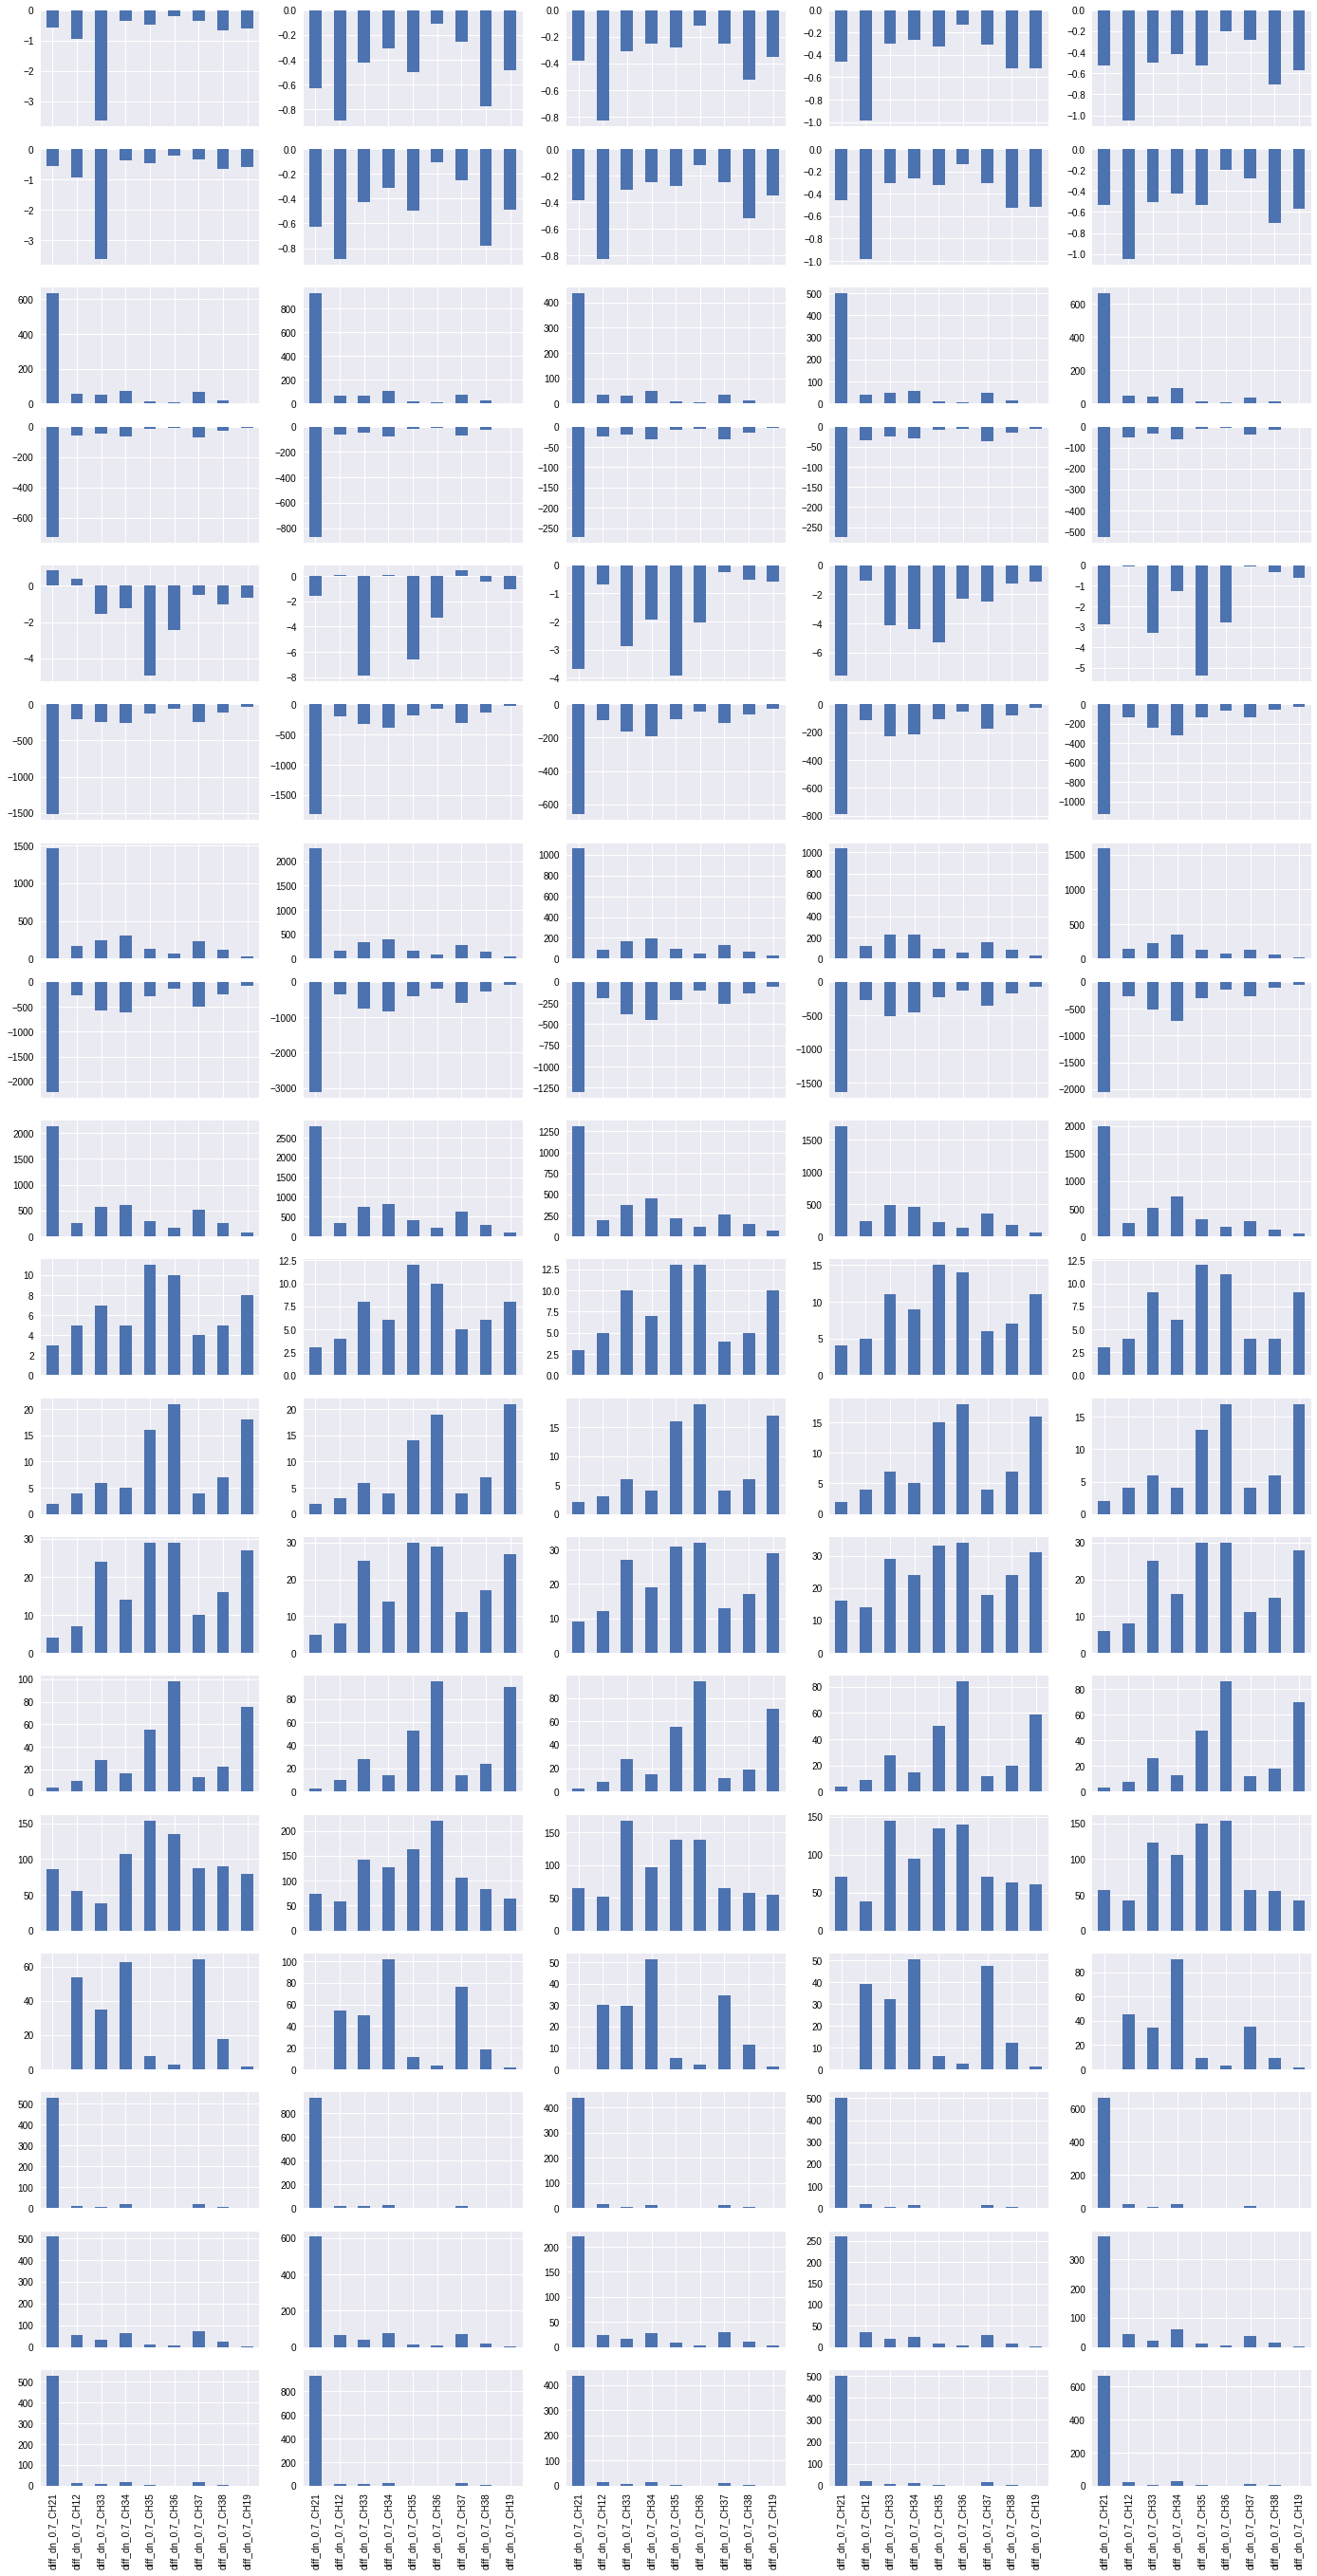

In [45]:
x = exp_dfs['AT']
_, axes = plt.subplots(18,5, figsize=(24,48), sharex=True)
cols = ['min_diff_dn', 'min_diff_dn', 'max_diff_dn', 'min_diff_up', 'max_diff_up', 'mag_up_0.3', 'mag_dn_0.3', 'mag_up_0.7', 'mag_dn_0.7', 'TC_up_0.3',
  'TC_dn_0.3', 'TC_up_0.7', 'TC_dn_0.7', 'T_rec', 'diff_dn_0.3', 'diff_dn_0.7', 'diff_up_0.3', 'diff_dn_0.7']

def __plot(y, cn, jx, ix):
  y[[c for c in y.index if c.startswith(cn)]].plot(kind='bar', ax=axes[jx][ix])

for ix, t in enumerate(x.target.unique()):
  y = x.loc[x.target==t, :].iloc[0]
  for jx, cn in enumerate(cols):
    __plot(y, cn, jx, ix)


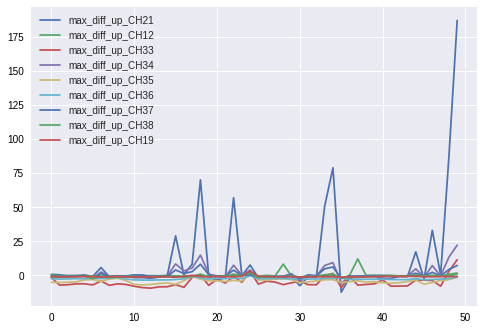

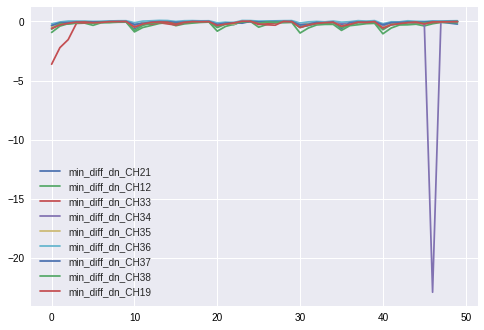

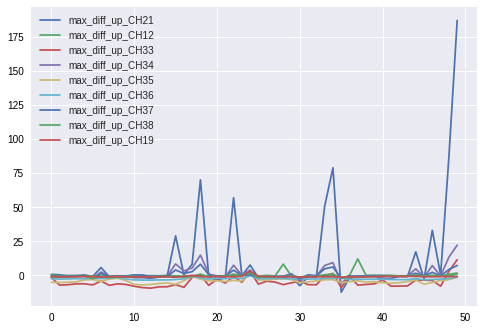

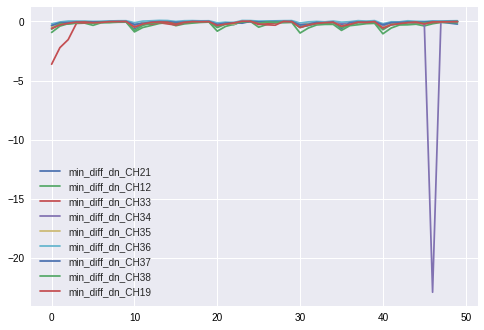

In [46]:
x[[c for c in x.columns if c.startswith('max_diff_up')]].plot()
x[[c for c in x.columns if c.startswith('min_diff_dn')]].plot()
x[[c for c in x.columns if c.startswith('max_diff_up')]].plot()
x[[c for c in x.columns if c.startswith('min_diff_dn')]].plot()

In [47]:
# features per channel
set(["_".join(c.split('_')[:-1]) for c in exp_dfs['AT'].columns if c not in ['x0', 'x1', 'x2'] and not c.startswith('target')])

{'TC_dn_0.1',
 'TC_dn_0.2',
 'TC_dn_0.3',
 'TC_dn_0.4',
 'TC_dn_0.5',
 'TC_dn_0.6',
 'TC_dn_0.7',
 'TC_dn_0.8',
 'TC_dn_0.9',
 'TC_up_0.1',
 'TC_up_0.2',
 'TC_up_0.3',
 'TC_up_0.4',
 'TC_up_0.5',
 'TC_up_0.6',
 'TC_up_0.7',
 'TC_up_0.8',
 'TC_up_0.9',
 'T_rec',
 'diff_at_peak',
 'diff_dn_0.1',
 'diff_dn_0.2',
 'diff_dn_0.3',
 'diff_dn_0.4',
 'diff_dn_0.5',
 'diff_dn_0.6',
 'diff_dn_0.7',
 'diff_dn_0.8',
 'diff_dn_0.9',
 'diff_up_0.1',
 'diff_up_0.2',
 'diff_up_0.3',
 'diff_up_0.4',
 'diff_up_0.5',
 'diff_up_0.6',
 'diff_up_0.7',
 'diff_up_0.8',
 'diff_up_0.9',
 'mag_dn_0.1',
 'mag_dn_0.2',
 'mag_dn_0.3',
 'mag_dn_0.4',
 'mag_dn_0.5',
 'mag_dn_0.6',
 'mag_dn_0.7',
 'mag_dn_0.8',
 'mag_dn_0.9',
 'mag_peak',
 'mag_up_0.1',
 'mag_up_0.2',
 'mag_up_0.3',
 'mag_up_0.4',
 'mag_up_0.5',
 'mag_up_0.6',
 'mag_up_0.7',
 'mag_up_0.8',
 'mag_up_0.9',
 'max_diff',
 'max_diff_dn',
 'max_diff_up',
 'min_diff',
 'min_diff_dn',
 'min_diff_up'}

In [48]:
def cv_run(exp_df, target_sz=5, target_column='target'):
  exp_df = exp_df.sample(frac=1.) # shuffle
  
  X = exp_df.drop(['x0', 'x1', 'x2', 'target', 'target_k', 'target_p'], axis=1)
  y = exp_df[target_column]

  model = CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU")
  cv_params = model.get_params()
  cv_params.update({
    'loss_function': 'MultiClass'
  })
  cv_data = cv(
    Pool(X, label=y),
    cv_params,
    plot=False,
    verbose=False,
    stratified=True
  )
  ix = np.argmax(cv_data['test-Accuracy-mean'])
  mean = np.max(cv_data['test-Accuracy-mean'])
  std = cv_data['test-Accuracy-std'][ix]
  print(f"mean({mean:.2f}) ±{std:.2f}")
  model.eval_metrics(cv_data, ['Precision'])

In [49]:
from catboost.utils import get_confusion_matrix
def fit_cv_run(exp_df, test_sz=0, target_column='target'):
  exp_df = exp_df.sample(frac=1.)
  
  X = exp_df.drop(['x0', 'x1', 'x2', 'target', 'target_k', 'target_p'], axis=1)
  y = exp_df[target_column]

  num_classes = y.nunique()
  cm = np.zeros((num_classes, num_classes))
  skf = StratifiedKFold(n_splits=3, shuffle=False)
  accs, losses = [], []
  for train_index, val_index in skf.split(X, y):
    X_train, X_validation, y_train, y_validation = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
    model = CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU")
    model.fit(X_train, y_train, eval_set=(X_validation, y_validation), verbose=False) # fit 
    score = model.get_best_score()
    #print("score=", score)
    acc = score['validation']['Accuracy']
    loss = score['validation']['MultiClass']
    accs.append(acc)
    losses.append(loss)
    cm += np.array(get_confusion_matrix(model, Pool(X_validation, y_validation)))
  accs = np.array(accs)    
  losses = np.array(losses)    
  return cm/cm.sum(axis=-1), accs.mean(), accs.std(), losses.mean(), losses.std(), model.classes_

'AT' cv run
['A' 'AT11' 'AT13' 'AT31' 'T']
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
accuracy mean: 1.0000±0.0000
loss mean: 0.1364±0.0587
'AX' cv run
['A' 'AX11' 'AX13' 'AX31' 'X']
[[1.  0.  0.  0.  0. ]
 [0.  0.9 0.1 0.  0. ]
 [0.  0.1 0.8 0.1 0. ]
 [0.  0.  0.1 0.9 0. ]
 [0.  0.  0.  0.  1. ]]
accuracy mean: 0.9608±0.0277
loss mean: 0.2656±0.0898
'TX' cv run
['T' 'TX11' 'TX13' 'TX31' 'X']
[[1.  0.  0.  0.  0. ]
 [0.  0.9 0.  0.  0.1]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.1 0.  0.  0.9]]
accuracy mean: 0.9804±0.0277
loss mean: 0.2531±0.0657


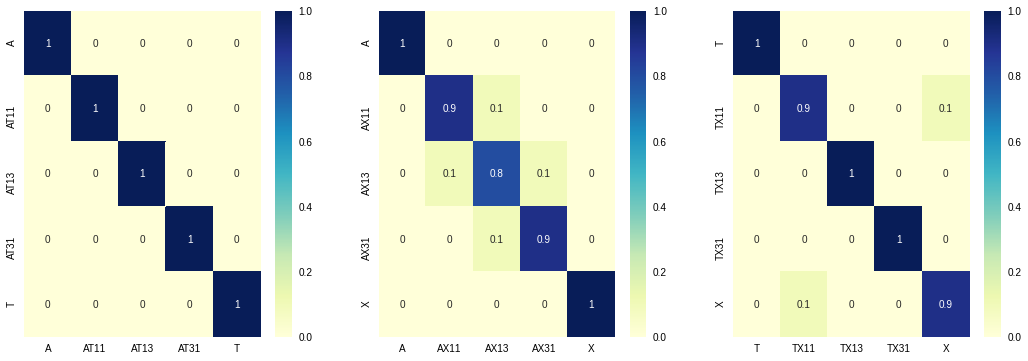

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, k in enumerate(exp_dfs):
  print(f"'{k}' cv run")
  cm, acc_mean, acc_std, loss_mean, loss_std, classes = fit_cv_run(exp_dfs[k])
  print(classes)
  print(cm)
  print(f"accuracy mean: {acc_mean:.4f}±{acc_std:.4f}")
  print(f"loss mean: {loss_mean:.4f}±{loss_std:.4f}")
  sns.heatmap(cm, cmap="YlGnBu", annot=True, xticklabels=classes, yticklabels=classes, ax=axes[i]);

['A' 'AT11' 'AT13' 'AT31' 'AX11' 'AX13' 'AX31' 'T' 'TX11' 'TX13' 'TX31'
 'TXA111' 'X']
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.9 0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.9 0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.7 0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.9 0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.9 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.8]]
accuracy mean: 0.931±0.038
loss mean: 0.380±0.076


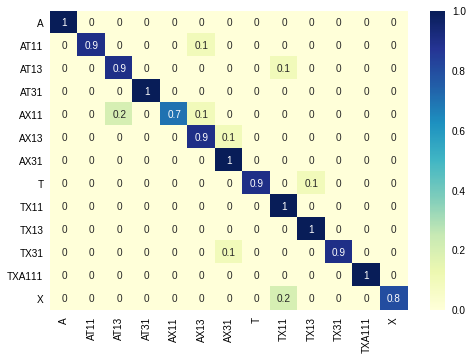

In [51]:
cm, acc_mean, acc_std, loss_mean, loss_std, classes = fit_cv_run(exp_df_all)
print(classes)
print(cm)
print(f"accuracy mean: {acc_mean:.3f}±{acc_std:.3f}")
print(f"loss mean: {loss_mean:.3f}±{loss_std:.3f}")
sns.heatmap(cm, cmap="YlGnBu", annot=True, xticklabels=classes, yticklabels=classes)

In [52]:
def fit_run(exp_df, test_sz=0, target_column='target'):
  exp_df = exp_df.sample(frac=1.)
  
  X = exp_df.drop(['x0', 'x1', 'x2', 'target', 'target_k', 'target_p'], axis=1)
  y = exp_df[target_column]

  if test_sz > 0:
    X_test = X.iloc[-test_sz:,:]  
    y_test = np.array(y.iloc[-test_sz:])
    print(X_test.shape, end=" ")
  
    X = X.iloc[:-test_sz,:]
    y = y[:-test_sz]
  
  X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, stratify=y)
  print(X_train.shape, end=" ")
  print(X_validation.shape, end= " ")
  
  model = CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU")
  model.fit(X_train, y_train, eval_set=(X_validation, y_validation), verbose=False) # fit 
  print(model.classes_)
  
  if test_sz > 0: 
    pred = model.predict(X_test) # predict
    pred = np.squeeze(pred)
    #pred_proba = model.predict_proba(X_test) # predict prob
    print("predicted=", pred)
    print(" expected=", y_test)
    print(" test accuracy=", (pred==y_test).sum()/test_sz)

  print(model.get_best_score())
  print(model.get_feature_importance(prettified=True)[:10])

In [53]:
#for k in exp_dfs:
#  print(f"'{k}' cv run")
#  cv_run(exp_dfs[k])

'AT' cv run
mean(0.98) ±0.04


CatBoostError: ignored

In [ ]:
print("cv run all")
cv_run(exp_df_all)

In [ ]:
# cv run w/o TXA111
cv_run(exp_df_all[exp_df_all.target != 'TXA111'])

In [ ]:
for k in exp_dfs:
  print(f"'{k}' fit run")
  fit_run(exp_dfs[k])

In [ ]:
fit_run(exp_df_all[exp_df_all.target != 'TXA111'])

In [ ]:
fit_run(exp_df_all)

In [56]:
# multi-label encoding
for t in "ATX":
  exp_df_all[f'target_{t}'] = exp_df_all.target.str.contains(t).astype('int')
  
# multi-label fit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold

def multi_label_cv_run(exp_df, test_sz=0):
  exp_df = exp_df.sample(frac=1.)
  X = exp_df.drop([c for c in exp_df.columns if c.startswith('target')] + ["x0", "x1", "x2"], axis=1)
  y = exp_df.target
  y_hot = exp_df[["target_A", "target_T", "target_X"]]

  if test_sz > 0:
    X_test = X.iloc[-test_sz:,:]  
    y_test = np.array(y.iloc[-test_sz:])
    print(X_test.shape, end=" ")
  
    X = X.iloc[:-test_sz,:]
    y = y[:-test_sz]

  models, scores = [], []
  skf = StratifiedKFold(shuffle=True)
  for train_index, val_index in skf.split(X, y):
    X_train, X_validation, y_train, y_validation = X.iloc[train_index], X.iloc[val_index], y_hot.iloc[train_index], y_hot.iloc[val_index]
    #TODO: how to use val set in fitting?
    ovr = OneVsRestClassifier(estimator=CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU"))
    ovr.fit(X_train, y_train)
    score = ovr.score(X_validation, y_validation)
    print("score=", score)
    scores.append(score)
    models.append(ovr)

  print("mean val score=", np.array(scores).mean(), "std=", np.array(scores).std()) 

  #TODO: k-hot decoding
  #TODO: accuracy calculation/meaning
  if test_sz > 0: 
    pred = ovr.predict(X_test) # predict
    pred = np.squeeze(pred)
    #pred_proba = model.predict_proba(X_test) # predict prob
    print("predicted=\n", pred)
    print("expected=\n", y_test)
    print("test accuracy=", (pred==y_test).sum()/test_sz/3)

#TODO: multilabel regression

In [57]:
multi_label_cv_run(exp_df_all, test_sz=0)

Streaming output truncated to the last 5000 lines.
8:	learn: 0.4465450	total: 383ms	remaining: 42.2s
9:	learn: 0.4178740	total: 426ms	remaining: 42.1s
10:	learn: 0.4059797	total: 478ms	remaining: 43s
11:	learn: 0.3901572	total: 520ms	remaining: 42.8s
12:	learn: 0.3705004	total: 563ms	remaining: 42.7s
13:	learn: 0.3562629	total: 605ms	remaining: 42.6s
14:	learn: 0.3472356	total: 646ms	remaining: 42.4s
15:	learn: 0.3346156	total: 703ms	remaining: 43.2s
16:	learn: 0.3294198	total: 745ms	remaining: 43.1s
17:	learn: 0.3205329	total: 786ms	remaining: 42.9s
18:	learn: 0.3097079	total: 830ms	remaining: 42.8s
19:	learn: 0.2974761	total: 873ms	remaining: 42.8s
20:	learn: 0.2819819	total: 929ms	remaining: 43.3s
21:	learn: 0.2728388	total: 971ms	remaining: 43.2s
22:	learn: 0.2633427	total: 1.01s	remaining: 43.1s
23:	learn: 0.2540516	total: 1.06s	remaining: 43.1s
24:	learn: 0.2431552	total: 1.11s	remaining: 43.2s
25:	learn: 0.2369926	total: 1.17s	remaining: 43.7s
26:	learn: 0.2323695	total: 1.21s	r

## Autoencoder based Classifier

In [70]:
def prepare_ts(gas_sheets, exp_df):
  ts = []
  ys = []
  for _, row in exp_df.iterrows(): # one row corresponds to one experiment (one cycle of graph)
    gas_df = gas_sheets[row.target]
    ts.append(gas_df.loc[row[1]-48:row[1]+291].values)
    ys.append(rgastypes[row.target])
  ts = np.stack(ts, axis=0)    
  ys = np.stack(ys, axis=0)
  y_hot = exp_df[["target_A", "target_T", "target_X"]].values
  return ts, ys, y_hot
X, y, y_hot = prepare_ts(sheets_norm, exp_df_all)    

In [59]:
for i, s in enumerate(data): 
  data[i] = (data[i] - s.mean(axis=-1)[:,None]) / (s.std(axis=-1)[:,None] + 1e-5) # per channerintl

In [60]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import tensorflow.keras

def get_autoencoder(data):
  input_ = Input(shape=(data.shape[1], data.shape[2]), name='input')
  latent = tensorflow.keras.Sequential([
    Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    Dropout(rate=0.2),
    Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    Dropout(rate=0.2),
    Conv1D(filters=8, kernel_size=7, padding="valid", strides=2, activation="relu"),
  ], name='encoder')(input_)
  output = tensorflow.keras.Sequential([
    Conv1DTranspose(filters=8, kernel_size=7, padding="valid", strides=2, activation="relu"),
    Dropout(rate=0.2),
    Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    Dropout(rate=0.2),
    Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    Conv1DTranspose(filters=9, kernel_size=7, padding="same"),
  ], name='decoder')(latent)
  model = Model(inputs=input_, outputs=[output, latent])
  model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss=["mse"], loss_weights=[1.,0.])
  return model

model = get_autoencoder(data)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 340, 9)]          0         
_________________________________________________________________
encoder (Sequential)         (None, 40, 8)             6552      
_________________________________________________________________
decoder (Sequential)         (None, 340, 9)            7009      
Total params: 13,561
Trainable params: 13,561
Non-trainable params: 0
_________________________________________________________________


In [61]:
es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=20)
model.fit(data,data, epochs=200, verbose=2, validation_data=(data,data), callbacks=[es])

Epoch 1/200
5/5 - 0s - loss: 0.9636 - decoder_loss: 0.9636 - val_loss: 0.8762 - val_decoder_loss: 0.8762
Epoch 2/200
5/5 - 0s - loss: 0.7767 - decoder_loss: 0.7767 - val_loss: 0.5723 - val_decoder_loss: 0.5723
Epoch 3/200
5/5 - 0s - loss: 0.5937 - decoder_loss: 0.5937 - val_loss: 0.4418 - val_decoder_loss: 0.4418
Epoch 4/200
5/5 - 0s - loss: 0.4704 - decoder_loss: 0.4704 - val_loss: 0.4169 - val_decoder_loss: 0.4169
Epoch 5/200
5/5 - 0s - loss: 0.4104 - decoder_loss: 0.4104 - val_loss: 0.3343 - val_decoder_loss: 0.3343
Epoch 6/200
5/5 - 0s - loss: 0.3763 - decoder_loss: 0.3763 - val_loss: 0.3283 - val_decoder_loss: 0.3283
Epoch 7/200
5/5 - 0s - loss: 0.3544 - decoder_loss: 0.3544 - val_loss: 0.2934 - val_decoder_loss: 0.2934
Epoch 8/200
5/5 - 0s - loss: 0.3320 - decoder_loss: 0.3320 - val_loss: 0.2815 - val_decoder_loss: 0.2815
Epoch 9/200
5/5 - 0s - loss: 0.3046 - decoder_loss: 0.3046 - val_loss: 0.2680 - val_decoder_loss: 0.2680
Epoch 10/200
5/5 - 0s - loss: 0.2872 - decoder_loss: 0.

In [62]:
pred, latent = model.predict(data)

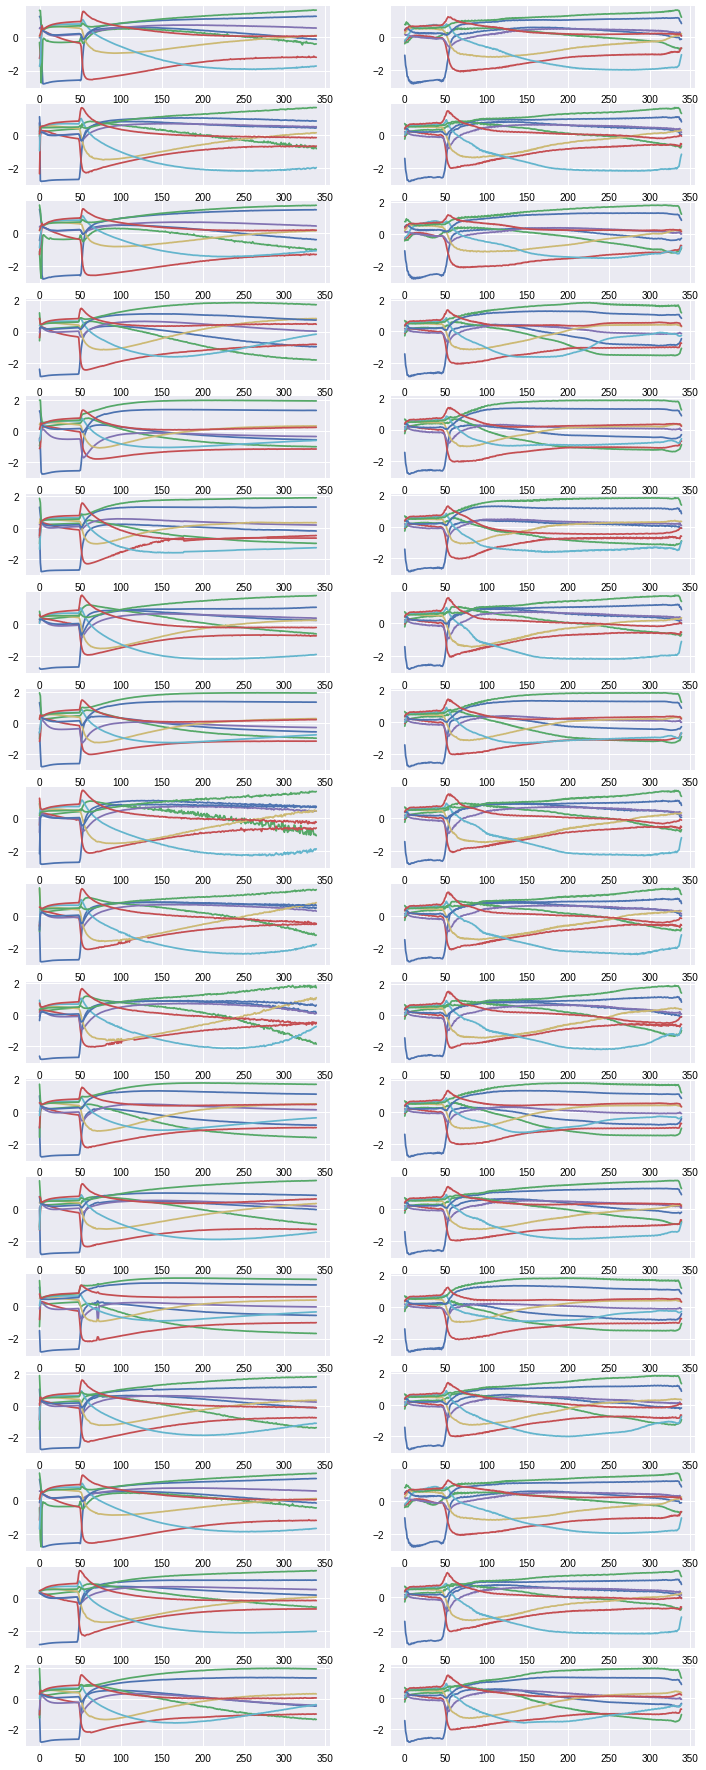

In [63]:
k = 18
rix = np.random.randint(0,data.shape[0], k)
_,axes = plt.subplots(k, 2, figsize=(12,32))
for i, r in enumerate(rix):
  axes[i,0].plot(data[r]);
  axes[i,1].plot(pred[r]);

In [78]:
#TODO: multi-label, regression
import tensorflow.keras.optimizers
from tensorflow.keras import regularizers
def get_classifier(latent, num_classes):
    input_layer = Input(shape=(latent.shape[1],))
    x = input_layer
    x = Dense(1280, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(640, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(320, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    out = Dense(num_classes, activation='softmax')(x)
    #out = Dense(3, activation='sigmoid')(x)
    m = Model(inputs=input_layer, outputs=out)
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0005) 
    m.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return m

In [82]:
latent = latent.reshape(latent.shape[0], -1)
num_classes = len(set(target))
models = []
val_accs = []

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)
for tr_ix, val_ix in skf.split(latent, target):
  model = get_classifier(latent, num_classes)
  es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=0, patience=30)
  h = model.fit(latent[tr_ix], target[tr_ix], epochs=400, verbose=0, validation_data=(latent[val_ix], target[val_ix]), callbacks=[es])
  val_acc = model.evaluate(latent[val_ix], target[val_ix])[1]
  val_accs.append(val_acc)
  models.append(model)

val_accs = np.array(val_accs)
print(val_accs.mean(), val_accs.std())

2/2 [==============================] - 0s 4ms/step - loss: 0.2969 - accuracy: 0.9302
0.9538407325744629 0.018994814553315503


In [91]:
import tensorflow.keras.backend as K
y_hat = tf.argmax(model.predict(latent[val_ix]), -1)
y = target[val_ix]
t = (y_hat == y)
print("val acc=", K.mean(t).numpy())

val acc= 0.9302326
